# Environment Setup and Function Definitions

Before diving into our analysis, it's crucial to establish a solid foundation by setting up our analytical environment. This initial step involves configuring the necessary libraries and tools that will empower our data processing and visualization tasks. Following the environment setup, we will proceed to define a series of functions tailored to our specific analytical needs. These functions are designed to streamline the data manipulation, analysis, and visualization processes, ensuring a smooth and efficient workflow throughout our project. By carefully preparing our environment and crafting these essential functions, we lay the groundwork for a comprehensive and insightful analysis.



In [1]:
# set up the environment 
# Read the content of the setup script
setup_script = 'Setup/step2.py'

with open(setup_script, 'r') as file:
    setup_code = file.read()

# Execute the setup script
exec(setup_code)

The data has been preprocessed to ensure it is in a format compatible with the defined functions.

In [2]:


# Open the JSON file
with open('ProcessedData/sampled_year_2010_records.json', 'r', encoding='utf-8') as json_file:
    # Initialize lists to store data
    year_data = []
    n_citation_data = []
    abstract_data = []

    # Iterate through each line in the JSON file
    for line in json_file:
        try:
            # Parse each line as a JSON object
            record = json.loads(line)
            
            # Extract the desired fields
            year = record.get('Year', '')
            n_citation = record.get('n_citation', '')
            abstract = record.get('Abstract', '')

            # Append the data to the respective lists
            year_data.append(year)
            n_citation_data.append(n_citation)
            abstract_data.append(abstract)
        except json.JSONDecodeError:
            # Handle invalid JSON lines (if any)
            print(f"Skipping invalid JSON line: {line}")

# Define file names for CSV files
year_csv_file = 'ProcessedData/year_data.csv'
n_citation_csv_file = 'ProcessedData/n_citation_data.csv'
abstract_csv_file = 'ProcessedData/abstract_data.csv'

# Write data to CSV files
with open(year_csv_file, 'w', newline='', encoding='utf-8') as year_csv:
    year_writer = csv.writer(year_csv)
    year_writer.writerow(['Year'])
    year_writer.writerows(zip(year_data))

with open(n_citation_csv_file, 'w', newline='', encoding='utf-8') as n_citation_csv:
    n_citation_writer = csv.writer(n_citation_csv)
    n_citation_writer.writerow(['n_citation'])
    n_citation_writer.writerows(zip(n_citation_data))

with open(abstract_csv_file, 'w', newline='', encoding='utf-8') as abstract_csv:
    abstract_writer = csv.writer(abstract_csv)
    abstract_writer.writerow(['Abstract'])
    abstract_writer.writerows(zip(abstract_data))

print(f'Data saved to {year_csv_file}, {n_citation_csv_file}, and {abstract_csv_file}')


Data saved to ProcessedData/year_data.csv, ProcessedData/n_citation_data.csv, and ProcessedData/abstract_data.csv


In my previous thesis, I thoroughly explored the NLP process for topic modeling using Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF). I incorporated best practices identified in prior research to ensure robust and accurate results. The following steps were used:

1. **Loading Data**: Reads the dataset from a CSV file.
2. **Text Cleaning**: Removes punctuation and converts text to lowercase.
3. **Tokenization**: Splits text into individual words.
4. **Lemmatization**: Reduces words to their base form.
5. **Stopwords Removal**: Removes common stopwords.
6. **Dictionary Creation**: Creates a dictionary mapping words to unique IDs.
7. **Corpus Creation**: Converts text data into a bag-of-words format.

In [168]:


EN = pd.read_csv('ProcessedData/abstract_data.csv')
EN['text_processed'] = EN['Abstract'].map(lambda x: re.sub('[,\\.!?()]', '', x))
EN['text_processed'] = EN['text_processed'].map(lambda x: x.lower())
EN['text_word'] = EN['text_processed'].map(lambda x: re.sub('[,\\.!?()]', '', x).lower().split())
EN['word_lem'] = lemmatization(EN['text_word'], notags=True,language='EN')
final=remove_stopwords(EN['word_lem'],EN['word_lem'],language='EN',num_freq_stopwords=40,extrastopwords=[])
id2word = corpora.Dictionary(final)
corpus = [id2word.doc2bow(text) for text in final]

two models are created. a random state of 88 is set. 

In [169]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=20,random_state=88)
nmf_model = Nmf(corpus=corpus, id2word=id2word,num_topics=20,random_state=88)

In [171]:
lda_model.show_topic(3, 100)

[('$', 0.012650117),
 ('design', 0.0081480825),
 ('high', 0.0058669853),
 ('at', 0.0054125832),
 ('/', 0.0052517373),
 ('video', 0.0045930813),
 ('processor', 0.004336765),
 ('performance', 0.004206914),
 ('set', 0.004092542),
 ('word', 0.004091234),
 ('power', 0.0040701176),
 ('bit', 0.0040569515),
 ('low', 0.00398156),
 ('%', 0.0038865437),
 ('core', 0.0038468565),
 ('frame', 0.0035691678),
 ('[', 0.0035237605),
 ('chip', 0.003515556),
 ("'s", 0.0034980061),
 ('tag', 0.0034150924),
 ('technology', 0.003368703),
 (']', 0.003316576),
 ('new', 0.0032472203),
 ('area', 0.0030642303),
 ('circuit', 0.0030231336),
 ('than', 0.0030075985),
 ('or', 0.0029939138),
 ('reduce', 0.0029867252),
 ('two', 0.002869711),
 ('technique', 0.0028580453),
 ('process', 0.0028576343),
 ('not', 0.0028088025),
 ('voltage', 0.0027747487),
 ('{', 0.0027469872),
 ('compare', 0.0027422502),
 ('code', 0.0027404896),
 ('improve', 0.0027186773),
 ('number', 0.0027183185),
 ('one', 0.0026845443),
 ('hardware', 0.00260

Calculate the topic distribution and save the file for further analysis. 

In [190]:
def topicdistribution(model, corpus, filename=None):
    topic_weights = []
    num_topics = model.num_topics
    for i, row_list in enumerate(model[corpus]):
        tw = [0] * num_topics
        for j, p in row_list:
            tw[j] = p
        topic_weights.append(tw)
    
    arr = pd.DataFrame(topic_weights).fillna(0).values
    tsne_model = TSNE(n_components=2, random_state=0, verbose=1,angle=0.99, init='pca')
    tsne = tsne_model.fit_transform(arr)

    toR = pd.DataFrame()
    toR['x_tsne'] = tsne[:, 0]
    toR['y_tsne'] = tsne[:, 1]
    toR['x_1_topic_probability'] = np.amax(arr, axis=1)
    toR['dominant_topic'] = np.argmax(arr, axis=1) 
    for t in range(num_topics):
        name = 'topic' + str(t)
        toR[name] = arr[:, t]

    if filename is not None:
        toR.to_csv(filename,index=False)

    return toR

topicdistribution(lda_model,corpus,filename='ProcessedData/lda.csv')
topicdistribution(nmf_model,corpus,filename='ProcessedData/nmf.csv')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8842 samples in 0.090s...
[t-SNE] Computed neighbors for 8842 samples in 2.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8842
[t-SNE] Computed conditional probabilities for sample 2000 / 8842
[t-SNE] Computed conditional probabilities for sample 3000 / 8842
[t-SNE] Computed conditional probabilities for sample 4000 / 8842
[t-SNE] Computed conditional probabilities for sample 5000 / 8842
[t-SNE] Computed conditional probabilities for sample 6000 / 8842
[t-SNE] Computed conditional probabilities for sample 7000 / 8842
[t-SNE] Computed conditional probabilities for sample 8000 / 8842
[t-SNE] Computed conditional probabilities for sample 8842 / 8842
[t-SNE] Mean sigma: 0.104219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.079468
[t-SNE] KL divergence after 1000 iterations: 1.799854
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8842 samples in 0.176s...
[t-SNE] Computed nei

,x_tsne,y_tsne,x_1_topic_probability,dominant_topic,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,10.899817,0.235941,0.223606,14,0.000000,0.027287,0.111995,0.000000,0.029296,0.000000,...,0.000000,0.209042,0.026397,0.000000,0.223606,0.000000,0.083752,0.000000,0.212675,0.000000
1,1.917597,-34.202465,0.365529,1,0.000000,0.365529,0.022199,0.000000,0.027146,0.000000,...,0.000000,0.091455,0.098301,0.178530,0.000000,0.081802,0.000000,0.000000,0.000000,0.000000
2,-17.966597,28.455248,0.278213,12,0.000000,0.000000,0.000000,0.000000,0.022443,0.145220,...,0.000000,0.155467,0.278213,0.000000,0.000000,0.000000,0.050029,0.044624,0.073143,0.028432
3,8.078309,-5.449518,0.284709,13,0.000000,0.025788,0.000000,0.000000,0.229081,0.000000,...,0.000000,0.269595,0.022796,0.284709,0.000000,0.000000,0.000000,0.000000,0.164842,0.000000
4,17.961988,-28.040997,0.338989,15,0.000000,0.184325,0.033969,0.000000,0.000000,0.000000,...,0.054164,0.288021,0.000000,0.000000,0.071560,0.338989,0.000000,0.011613,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8837,19.564381,-13.751108,0.346873,11,0.000000,0.068183,0.147217,0.000000,0.032202,0.000000,...,0.099727,0.346873,0.000000,0.111571,0.071807,0.000000,0.020872,0.000000,0.101548,0.000000
8838,-25.308477,-14.688014,0.394732,5,0.207365,0.012272,0.000000,0.037203,0.091361,0.394732,...,0.037585,0.000000,0.000000,0.000000,0.016451,0.000000,0.080068,0.000000,0.026138,0.000000
8839,-16.670441,-1.347622,0.303492,13,0.000000,0.069080,0.000000,0.055649,0.090981,0.136059,...,0.000000,0.026010,0.000000,0.303492,0.000000,0.000000,0.000000,0.000000,0.020147,0.000000
8840,7.430433,-38.363281,0.482874,1,0.000000,0.482874,0.000000,0.119705,0.000000,0.264563,...,0.000000,0.000000,0.000000,0.037063,0.000000,0.077918,0.000000,0.017877,0.000000,0.000000


In [113]:
import pickle
with open("ProcessedData/corpus.pkl", "wb") as f:
    pickle.dump(corpus, f)
with open("ProcessedData/final.pkl", "wb") as f:
    pickle.dump(final, f)


from gensim import models

# Assuming you have an LDA model named 'lda_model'
lda_model.save("ProcessedData/ldamodel")  # Save the model
nmf_model.save("ProcessedData/nmfmodel")  # Save the model

In [37]:
from gensim import models

# Assuming you have an LDA model named 'lda_model'
lda_model.save("ldamodel")  # Save the model
nmf_model.save("nmfmodel")  # Save the model
# To load the model later
#loaded_lda_model = models.LdaModel.load("your_model_filename")  # Load the model

Save the necessary data for statistical analysis as a CSV file for subsequent analysis.

In [193]:

combinecsv('ProcessedData/n_citation_data.csv','ProcessedData/lda.csv','ProcessedData/lda_for_regression.csv')
combinecsv('ProcessedData/n_citation_data.csv','ProcessedData/nmf.csv','ProcessedData/nmf_for_regression.csv')

,n_citation,x_tsne,y_tsne,x_1_topic_probability,dominant_topic,topic0,topic1,topic2,topic3,topic4,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,0,10.899817,0.235941,0.223606,14,0.000000,0.027287,0.111995,0.000000,0.029296,...,0.000000,0.209042,0.026397,0.000000,0.223606,0.000000,0.083752,0.000000,0.212675,0.000000
1,0,1.917597,-34.202465,0.365529,1,0.000000,0.365529,0.022199,0.000000,0.027146,...,0.000000,0.091455,0.098301,0.178530,0.000000,0.081802,0.000000,0.000000,0.000000,0.000000
2,10,-17.966597,28.455248,0.278213,12,0.000000,0.000000,0.000000,0.000000,0.022443,...,0.000000,0.155467,0.278213,0.000000,0.000000,0.000000,0.050029,0.044624,0.073143,0.028432
3,28,8.078309,-5.449518,0.284709,13,0.000000,0.025788,0.000000,0.000000,0.229081,...,0.000000,0.269595,0.022796,0.284709,0.000000,0.000000,0.000000,0.000000,0.164842,0.000000
4,3,17.961988,-28.040997,0.338989,15,0.000000,0.184325,0.033969,0.000000,0.000000,...,0.054164,0.288021,0.000000,0.000000,0.071560,0.338989,0.000000,0.011613,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8837,4,19.564380,-13.751108,0.346873,11,0.000000,0.068183,0.147217,0.000000,0.032202,...,0.099727,0.346873,0.000000,0.111571,0.071807,0.000000,0.020872,0.000000,0.101548,0.000000
8838,2,-25.308477,-14.688014,0.394732,5,0.207365,0.012272,0.000000,0.037203,0.091361,...,0.037585,0.000000,0.000000,0.000000,0.016451,0.000000,0.080068,0.000000,0.026138,0.000000
8839,1,-16.670440,-1.347622,0.303492,13,0.000000,0.069080,0.000000,0.055649,0.090981,...,0.000000,0.026010,0.000000,0.303492,0.000000,0.000000,0.000000,0.000000,0.020147,0.000000
8840,7,7.430433,-38.363280,0.482874,1,0.000000,0.482874,0.000000,0.119705,0.000000,...,0.000000,0.000000,0.000000,0.037063,0.000000,0.077918,0.000000,0.017877,0.000000,0.000000


In [142]:
citation = pd.read_csv('ProcessedData/n_citation_data.csv')
topics = topics_per_document(lda_model, corpus)
dominant = [point[1] for point in topics[0]]
citation['dominant']=pd.DataFrame(dominant)
citation

,n_citation,dominant
0,0,2
1,0,8
2,10,7
3,28,0
4,3,8
...,...,...
8837,4,3
8838,2,2
8839,1,0
8840,7,18


In [150]:
topics[1][2310]

[(0, 0.21910566),
 (3, 0.023168297),
 (7, 0.14923424),
 (8, 0.34562266),
 (11, 0.05981003),
 (17, 0.1952654)]

In [140]:
topics[0][0]

(0, 11)

In [61]:
mean_by_dominant = citation.groupby('dominant')['n_citation'].mean()

# Display the result
print(mean_by_dominant)

dominant
0     37.195858
1     23.227273
2     29.338736
3     51.754950
4     19.684564
5     32.205788
6     31.215686
7     37.204694
8     28.133333
9     11.907143
10    26.000000
11    30.840237
12    19.530928
13    29.283816
14    23.757709
15    33.535912
16    22.044444
17    34.869159
18    20.839679
19    22.057692
Name: n_citation, dtype: float64


In [62]:
citation.groupby('dominant')['n_citation'].count()

dominant
0     1159
1       66
2     1234
3      404
4      149
5      311
6      255
7      767
8      930
9      140
10      48
11     169
12     194
13     828
14     681
15     181
16      90
17     321
18     499
19     416
Name: n_citation, dtype: int64

     feature           VIF
0      const  13759.002211
1    topic_0    599.781680
2    topic_1     40.428041
3    topic_2    600.188739
4    topic_3    204.177214
5    topic_4     93.343202
6    topic_5    167.572287
7    topic_6    143.367405
8    topic_7    374.422696
9    topic_8    470.607933
10   topic_9     85.379518
11  topic_10     32.573883
12  topic_11    101.404371
13  topic_12    100.129695
14  topic_13    414.975805
15  topic_14    345.421780
16  topic_15     91.319638
17  topic_16     57.026647
18  topic_17    175.000068
19  topic_18    267.466788
20  topic_19    222.604674
Ridge Regression R^2: 0.0020653132711616617
Lasso Regression R^2: 0.0021372795594856164


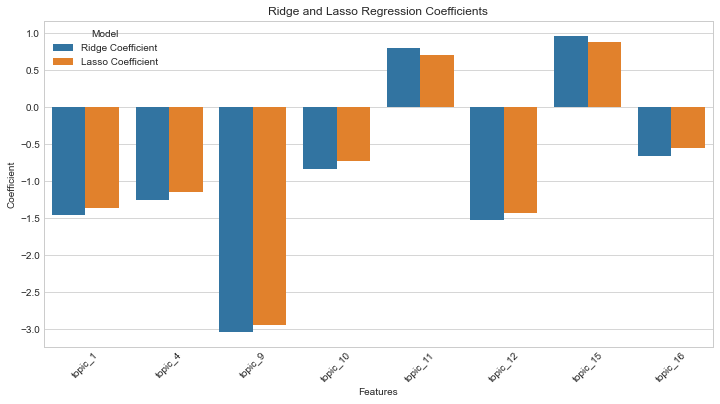

In [86]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Example loading data (replace with your actual data)


# Convert the loading data to a DataFrame
num_topics = 20  # Assume there are 20 topics
data = np.zeros((len(topics[1]), num_topics))

for i, doc in enumerate(topics[1]):
    for topic, load in doc:
        data[i, topic] = load

loading_df = pd.DataFrame(data, columns=[f'topic_{i}' for i in range(num_topics)])

# Example citation data (replace with your actual data)


# Combine the topic loadings and citations into a single DataFrame
data = pd.concat([loading_df, citation], axis=1)

# Prepare the independent variables (X) and dependent variable (y)
X = data.drop(columns=['n_citation', 'dominant'])
y = data['n_citation']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Check for multicollinearity with VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# Remove predictors with high VIF values (e.g., VIF > 10)
high_vif_features = vif_data[vif_data["VIF"] > 105]["feature"]
X_reduced = X.drop(columns=high_vif_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Standardize the data for regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Apply Lasso regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate the models
print(f"Ridge Regression R^2: {r2_score(y_test, y_pred_ridge)}")
print(f"Lasso Regression R^2: {r2_score(y_test, y_pred_lasso)}")

# Plot the coefficients from Ridge and Lasso regression
plt.figure(figsize=(12, 6))
coef_df = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Ridge Coefficient': ridge.coef_,
    'Lasso Coefficient': lasso.coef_
})
coef_df = coef_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')
sns.barplot(x='Feature', y='Coefficient', hue='Model', data=coef_df)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Ridge and Lasso Regression Coefficients')
plt.show()


In [87]:
citation

,n_citation,dominant
0,0,2
1,0,8
2,10,7
3,28,0
4,3,8
...,...,...
8837,4,3
8838,2,2
8839,1,0
8840,7,18


Original Skewness: 43.067564282507604
Log-transformed Skewness: 0.35857121470776276


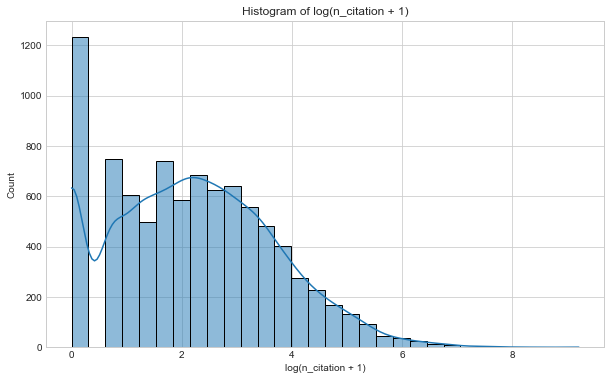

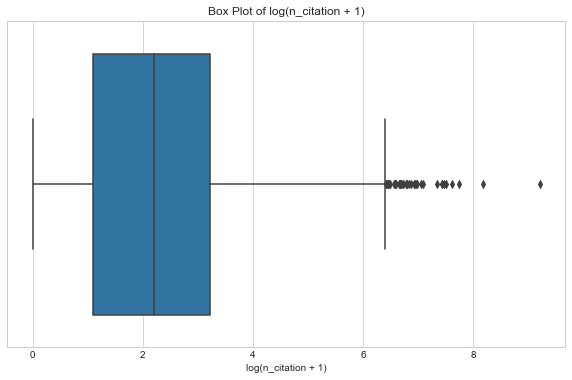

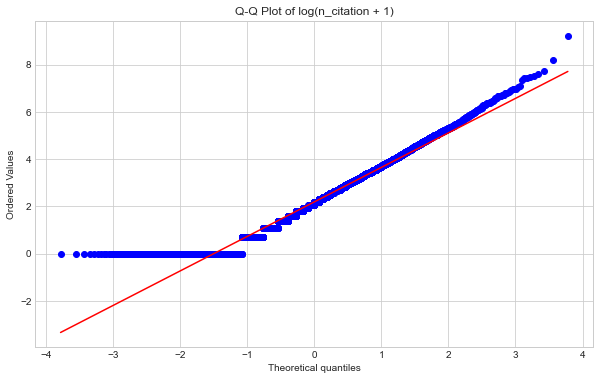

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, probplot



# Extract the dependent variable
y = citation['n_citation']

# Original Skewness
original_skewness = skew(y)
print(f'Original Skewness: {original_skewness}')

# 1. Apply Log Transformation
y_log = np.log1p(y)  # log1p is used to handle zero values by applying log(1 + y)

# 2. Re-check Skewness
log_skewness = skew(y_log)
print(f'Log-transformed Skewness: {log_skewness}')

# 3. Visualize the log-transformed distribution

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(y_log, kde=True, bins=30)
plt.xlabel('log(n_citation + 1)')
plt.title('Histogram of log(n_citation + 1)')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(y_log)
plt.xlabel('log(n_citation + 1)')
plt.title('Box Plot of log(n_citation + 1)')
plt.show()

# Q-Q Plot
plt.figure(figsize=(10, 6))
probplot(y_log, dist="norm", plot=plt)
plt.title('Q-Q Plot of log(n_citation + 1)')
plt.show()


Ridge Regression R^2: 0.02546782344664944
Lasso Regression R^2: -0.0010503985723790965


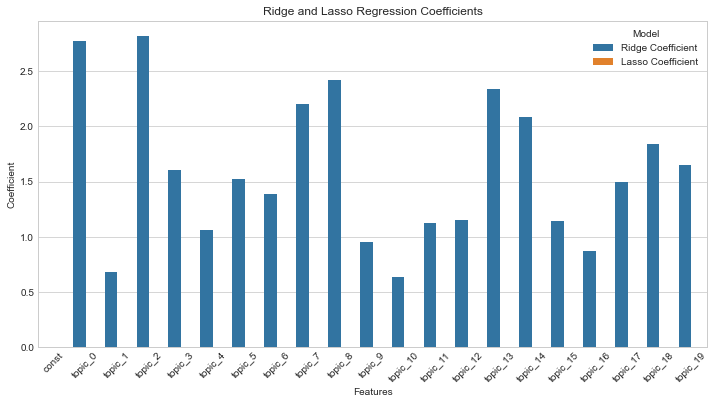

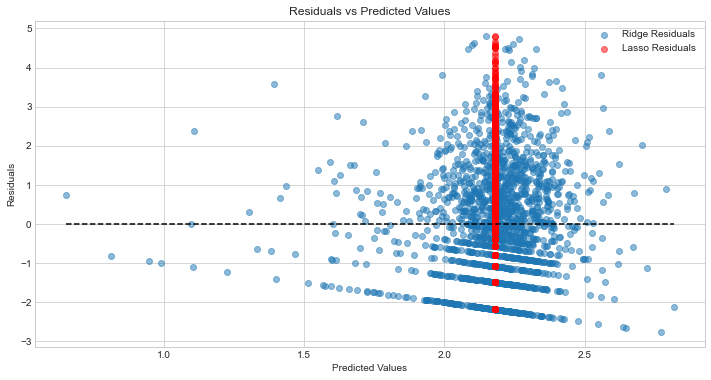

In [95]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Example loading data (replace with your actual data)


# Convert the loading data to a DataFrame
num_topics = 20  # Assume there are 20 topics
data = np.zeros((len(topics[1]), num_topics))

for i, doc in enumerate(topics[1]):
    for topic, load in doc:
        data[i, topic] = load

loading_df = pd.DataFrame(data, columns=[f'topic_{i}' for i in range(num_topics)])

# Example citation data (replace with your actual data)


# Combine the topic loadings and citations into a single DataFrame
data = pd.concat([loading_df, citation], axis=1)

# Prepare the independent variables (X) and dependent variable (y)
X = data.drop(columns=['n_citation', 'dominant'])
y = data['n_citation']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Log-transform the dependent variable
y_log = np.log1p(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Standardize the data for regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Apply Lasso regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate the models
print(f"Ridge Regression R^2: {r2_score(y_test, y_pred_ridge)}")
print(f"Lasso Regression R^2: {r2_score(y_test, y_pred_lasso)}")

# Evaluate the residuals
residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso

# Plot the coefficients from Ridge and Lasso regression
plt.figure(figsize=(12, 6))
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Ridge Coefficient': ridge.coef_,
    'Lasso Coefficient': lasso.coef_
})
coef_df = coef_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')
sns.barplot(x='Feature', y='Coefficient', hue='Model', data=coef_df)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Ridge and Lasso Regression Coefficients')
plt.show()

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5, label='Ridge Residuals')
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5, label='Lasso Residuals', color='red')
plt.hlines(0, min(y_pred_ridge), max(y_pred_ridge), colors='black', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:             n_citation   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     11.57
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           2.33e-37
Time:                        14:35:56   Log-Likelihood:                -15922.
No. Observations:                8842   AIC:                         3.189e+04
Df Residuals:                    8821   BIC:                         3.203e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.4950      1.829    -11.208      0.0

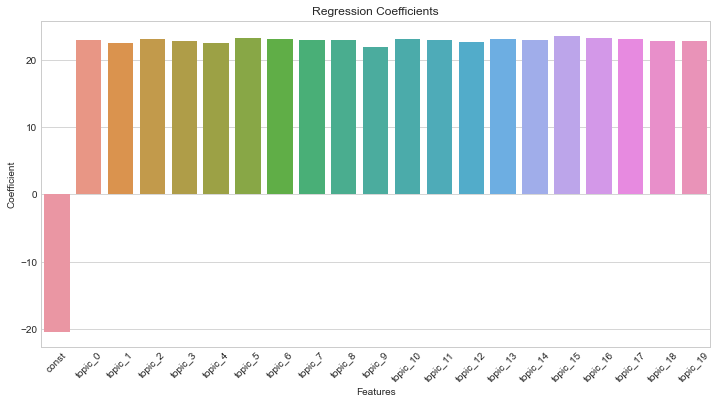

In [96]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Example loading data and citation data (replace with your actual data)
loading = topics[1]

# Example citation data


# Convert the loading data to a DataFrame
num_topics = 20  # Assume there are 20 topics
data = np.zeros((len(loading), num_topics))

for i, doc in enumerate(loading):
    for topic, load in doc:
        data[i, topic] = load

loading_df = pd.DataFrame(data, columns=[f'topic_{i}' for i in range(num_topics)])

# Combine the topic loadings and citations into a single DataFrame
data = pd.concat([loading_df, citation], axis=1)

# Prepare the independent variables (X) and dependent variable (y)
X = data.drop(columns=['n_citation','dominant'])
y = data['n_citation']
y_log = np.log1p(y)

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y_log, X).fit()

# Print the summary of the regression results
print(model.summary())

# Visualize the coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=model.params.index, y=model.params.values)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Regression Coefficients')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             n_citation   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.005
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           1.16e-05
Time:                        14:39:14   Log-Likelihood:                -16008.
No. Observations:                8842   AIC:                         3.206e+04
Df Residuals:                    8822   BIC:                         3.220e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1813      0.044     50.040      

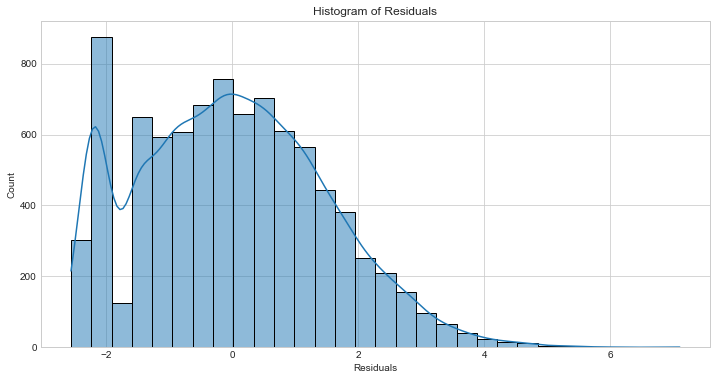

<Figure size 864x432 with 0 Axes>

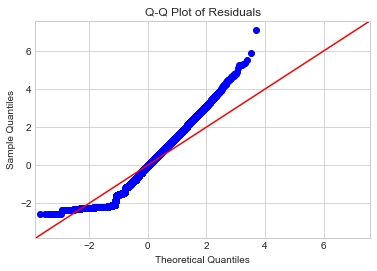

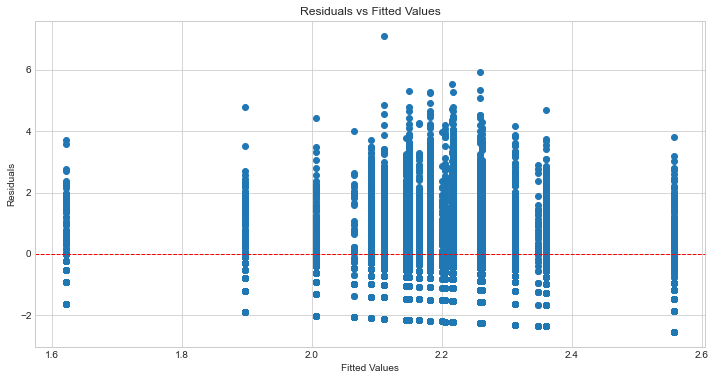

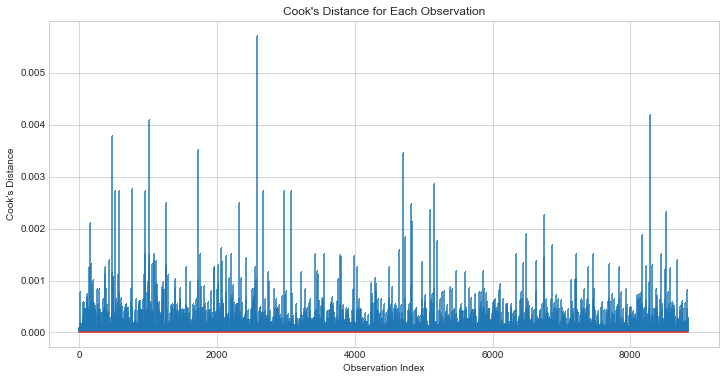

Influential points: [   9   55   66   86  107  109  116  126  133  150  172  175  182  191
  199  206  230  254  277  291  339  360  366  378  381  402  436  468
  476  483  486  488  520  533  552  561  564  577  582  602  607  619
  665  672  675  687  699  750  756  760  762  824  860  869  886  926
  934  953  956  983 1001 1004 1008 1017 1029 1044 1061 1079 1086 1108
 1118 1122 1123 1134 1136 1153 1203 1205 1211 1219 1233 1255 1256 1260
 1264 1265 1291 1324 1341 1348 1374 1388 1392 1394 1415 1455 1459 1462
 1491 1549 1553 1562 1610 1644 1666 1688 1718 1724 1727 1747 1749 1773
 1777 1790 1807 1826 1871 1906 1957 1959 1996 2007 2011 2021 2062 2064
 2075 2076 2077 2086 2088 2091 2124 2130 2168 2196 2205 2218 2221 2237
 2240 2275 2279 2283 2287 2295 2322 2324 2352 2364 2419 2426 2513 2519
 2524 2535 2542 2551 2572 2578 2617 2623 2663 2690 2741 2751 2826 2848
 2851 2867 2899 2939 2975 2981 3000 3072 3087 3148 3215 3261 3283 3300
 3342 3352 3426 3450 3464 3487 3503 3518 3519 3534 3558 3

AttributeError: module 'statsmodels.api' has no attribute 'robust_norms'

In [98]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, probplot


# One-hot encode the categorical variable 'dominant'
citation_encoded = pd.get_dummies(citation, columns=['dominant'], drop_first=True)

# Prepare the independent variables (X) and dependent variable (y)
X = citation_encoded.drop(columns=['n_citation'])
y = citation['n_citation']

# Log-transform the dependent variable
y_log = np.log1p(y)

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y_log, X).fit()

# Print the summary of the regression results
print(model.summary())

# Evaluate the residuals
residuals = model.resid

# Histogram of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q Plot of residuals
plt.figure(figsize=(12, 6))
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Residuals vs Fitted values plot
plt.figure(figsize=(12, 6))
plt.scatter(model.fittedvalues, residuals)
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Check for outliers using Cook's distance
influence = model.get_influence()
(c, p) = influence.cooks_distance

# Plot Cook's distance
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Observation")
plt.show()

# Identify high Cook's distance points
influential_points = np.where(c > 4/len(c))[0]
print("Influential points:", influential_points)

# Remove influential points and refit the model
X_influential = X.drop(index=influential_points)
y_log_influential = y_log.drop(index=influential_points)

model_influential = sm.OLS(y_log_influential, X_influential).fit()

# Print the summary of the regression results after removing influential points
print(model_influential.summary())

# Robust regression
robust_model = sm.RLM(y_log, X, M=sm.robust_norms.HuberT()).fit()
print(robust_model.summary())

# Visualize the coefficients from the robust regression
plt.figure(figsize=(12, 6))
sns.barplot(x=robust_model.params.index, y=robust_model.params.values)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Robust Regression Coefficients')
plt.show()


In [127]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.robust.norms import HuberT



# Filter records where the number of citations is less than 100
citation_filtered = citation[citation['n_citation'] >50]

# One-hot encode the categorical variable 'dominant'
citation_encoded = pd.get_dummies(citation_filtered, columns=['dominant'], drop_first=True)

# Prepare the independent variables (X) and dependent variable (y)
X = citation_encoded.drop(columns=['n_citation'])
y = citation_filtered['n_citation']

# Log-transform the dependent variable
y_log = y

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the initial linear regression model
initial_model = sm.OLS(y_log, X).fit()

print(initial_model.summary())




KeyError: "None of [Index(['dominant'], dtype='object')] are in the [columns]"

                            OLS Regression Results                            
Dep. Variable:             n_citation   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8480
Date:                Sun, 21 Jul 2024   Prob (F-statistic):              0.650
Time:                        14:26:44   Log-Likelihood:                -56395.
No. Observations:                8842   AIC:                         1.128e+05
Df Residuals:                    8822   BIC:                         1.130e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          18.8848      7.298      2.588      

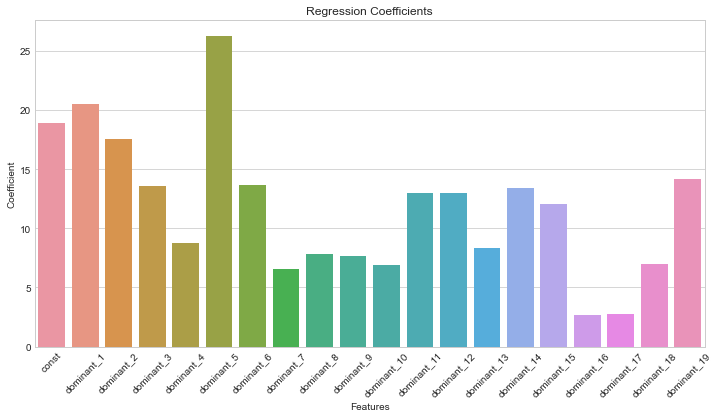

In [90]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns



# One-hot encode the categorical variable 'dominant'
citation_encoded = pd.get_dummies(citation, columns=['dominant'], drop_first=True)

# Prepare the independent variables (X) and dependent variable (y)
X = citation_encoded.drop(columns=['n_citation'])
y = citation['n_citation']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

# Visualize the coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=model.params.index, y=model.params.values)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Regression Coefficients')
plt.show()